In [1]:
!pip install --upgrade dagshub mlflow imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 57.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 83.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: 

In [2]:
import dagshub
dagshub.init(repo_owner='alaki22', repo_name='Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=fa344c7a-4db7-4f96-a3fa-5e691cdff828&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=f36ee7b143d69dd1dcfbc73b9d37610921fb585d5a2972434982b7b74affd49f




Output()

Accessing as alaki22

Initialized MLflow to track repo "alaki22/Fraud-Detection"

Repository alaki22/Fraud-Detection initialized!

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [10]:
train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

train_df = train_transaction.merge(train_identity, on="TransactionID", how="left")

In [11]:
y = train_df['isFraud']
X = train_df.drop(columns = ['isFraud'])

In [12]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (413378, 433)
Validation size: (88581, 433)
Test size: (88581, 433)


Feature Engineering

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class FraudDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 nan_threshold=0.95,
                 flag_threshold=0.1,
                 num_strategy='median', 
                 cat_strategy='most_frequent'):
        self.nan_threshold = nan_threshold
        self.flag_threshold = flag_threshold
        self.num_strategy = num_strategy
        self.cat_strategy = cat_strategy
        self.columns_to_drop_ = []
        self.impute_values_ = {}
        self.flags_to_add_ = []

    def fit(self, X, y=None):
       
        na_ratios = X.isna().mean()
        self.columns_to_drop_ = na_ratios[na_ratios >= self.nan_threshold].index.tolist()
        print(self.columns_to_drop_)
        
        
        remaining_cols = [c for c in X.columns if c not in self.columns_to_drop_]
        num_cols = X[remaining_cols].select_dtypes(include='number').columns
        cat_cols = X[remaining_cols].select_dtypes(exclude='number').columns
        
        for col in num_cols:
            self.impute_values_[col] = X[col].median() if self.num_strategy == 'median' else X[col].mean()
            
        for col in cat_cols:
            mode = X[col].mode()
            self.impute_values_[col] = mode[0] if not mode.empty else 'MISSING'
            
        return self

    def transform(self, X):
        X = X.copy()
        
        cols_to_drop = [col for col in self.columns_to_drop_ if col in X.columns]
        X = X.drop(columns=cols_to_drop)
    
        for col, val in self.impute_values_.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)
                
        return X

  

In [14]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder


class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 3):
        self.threshold = threshold
        self.woe_mappings = {}
        self.target_encodings = {}
        self.ohe = None
        
    def fit(self, X, y=None):
        df = X.copy()

        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        num_cols = [col for col in df.columns if df[col].dtype != 'object']
        
        
        n_unique = df[cat_cols].nunique()
        na_rate = df[cat_cols].isna().mean()

        self.woe_columns = list(n_unique[(n_unique > self.threshold) & (na_rate <= 0.5)].index)
        self.one_hot_columns = list(n_unique[(n_unique <= self.threshold) & (na_rate <= 0.5)].index)
        
        df['__target__'] = y

       

        # --- WOE ENCODING ---
        self.woe_columns_fill_na = {
            col: X[col].mode().iloc[0] if not X[col].mode().empty else 'missing'
            for col in self.woe_columns
        }
        
        self.woe_mappings = {}
        for col in self.woe_columns:
            groups = df.groupby(col)['__target__'].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            self.woe_mappings[col] = groups['woe'].to_dict()


        # --- ONE-HOT ENCODER ---
        self.ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, dtype=int)
        self.ohe.fit(X[self.one_hot_columns])

        return self

    def transform(self, X):
        X_transformed = X.copy()


        # --- Apply WOE ---
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)


        print("Check Nans")
        n = X_transformed.isna().mean()

        na_cols = list(n[n > 0].index)

        print(na_cols)

        for col in na_cols:
            name, pr = col.rsplit("_", 1)
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])


        # --- Apply One-Hot Encoding ---
        ohe_array = self.ohe.transform(X[self.one_hot_columns])
        ohe_columns = self.ohe.get_feature_names_out(self.one_hot_columns)
        df_ohe = pd.DataFrame(ohe_array, columns=ohe_columns, index=X.index)

        X_transformed.drop(columns=self.one_hot_columns, inplace=True)
        X_transformed = pd.concat([X_transformed, df_ohe], axis=1)

        return X_transformed


Feature Selection

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_drop_ = []

    def fit(self, X, y=None):
        corr_matrix = pd.DataFrame(X).corr().abs()
        high_corr_pairs = [
            (corr_matrix.columns[i], corr_matrix.columns[j])
            for i in range(len(corr_matrix.columns))
            for j in range(i + 1, len(corr_matrix.columns))
            if corr_matrix.iloc[i, j] > self.threshold
        ]
        
        features_to_drop = []
        for feat1, feat2 in high_corr_pairs:
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                features_to_drop.append(feat1)
            else:
                features_to_drop.append(feat2)
        
        self.features_to_drop_ = list(set(features_to_drop))
        return self

    def transform(self, X):
        print(self.features_to_drop_)
        return X.drop(columns=self.features_to_drop_, errors='ignore')


Training

In [16]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report

pipeline = ImbPipeline([
    ('preprocessor', FraudDataPreprocessor(
        nan_threshold=0.95,     
        flag_threshold=0.05,   
        num_strategy='median', 
        cat_strategy='most_frequent'
    )),  
    ('custom_encoding', CustomPreprocessor(threshold=3)),  
    ('correlation_drop', CorrelationFeatureDropper(threshold=0.8)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,       
        max_depth=10,            
        min_samples_split=50,    
        min_samples_leaf=20,     
        class_weight='balanced', 
        random_state=42          
    ))  
])

pipeline.fit(X_train, y_train)

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_proba > 0.5).astype(int)
y_val_pred = (y_val_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\n===== Model Performance (ROC AUC and F1 Score) =====")
print(f"Train ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")

print(f"Train F1 Score: {f1_train:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))


['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Check Nans
[]
['V278', 'V249', 'V228', 'V66', 'V60', 'V61', 'V179', 'V256', 'V163', 'V112', 'V25', 'V74', 'V22', 'V137', 'V73', 'V133', 'V206', 'V248', 'V19', 'V125', 'V246', 'V288', 'V331', 'id_15_New', 'V242', 'V44', 'V192', 'V4', 'V36', 'V97', 'ProductCD_woe', 'V177', 'V51', 'V159', 'V335', 'V49', 'V152', 'V273', 'V218', 'V202', 'V276', 'V264', 'V252', 'V178', 'V334', 'V157', 'V187', 'V182', 'V116', 'V306', 'V144', 'D2', 'V198', 'V154', 'V311', 'V230', 'C10', 'V261', 'V251', 'V200', 'V54', 'V92', 'V94', 'V79', 'V106', 'V164', 'V64', 'V337', 'V195', 'V134', 'V151', 'V11', 'V300', 'V100', 'V327', 'V136', 'C1', 'V294', 'V227', 'V148', 'V119', 'V161', 'id_29_NotFound', 'C11', 'V156', 'V135', 'V33', 'V332', 'V128', 'V34', 'V233', 'V102', 'V329', 'V15', 'V292', 'V272', 'V254', 'V80', 'V103', 'V16', 'V143', 'V104', 'V86', 'V131', 'V155', 'V237', 'C12', 'V43', 'V221', 'V145', 'V186', 'V196', 'V267', 'V285', 'V

===== Model Performance (ROC AUC and F1 Score) =====

Train ROC AUC: 0.8871

Validation ROC AUC: 0.8794

Test ROC AUC: 0.8817

Train F1 Score: 0.2987

Validation F1 Score: 0.2954

Test F1 Score: 0.2979

2025/04/27 15:51:07 INFO mlflow.tracking.fluent: Experiment with name 'random_forest' does not exist. Creating a new experiment.
2025/04/27 15:51:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


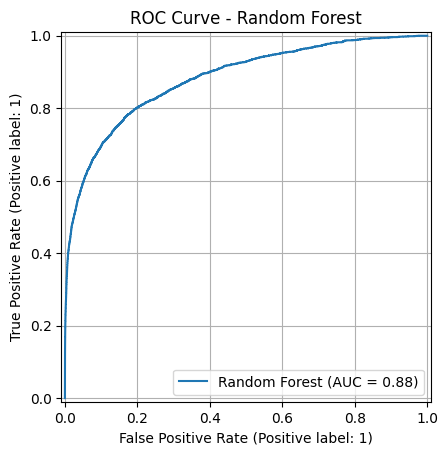

🏃 View run random_forest at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/4/runs/63eaacb4a1ff44f0995e7025cd27cadb
🧪 View experiment at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/4


In [17]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

mlflow.set_experiment("random_forest")  
with mlflow.start_run(run_name="random_forest"):
    mlflow.sklearn.log_model(
        sk_model=pipeline,          
        artifact_path="model",      
        registered_model_name=None   
    )
    

    mlflow.log_metric("roc_auc_train", roc_auc_train)
    mlflow.log_metric("roc_auc_val", roc_auc_val)
    mlflow.log_metric("roc_auc_test", roc_auc_test)


    RocCurveDisplay.from_predictions(
        y_test, 
        y_test_proba, 
        name="Random Forest"
    )

    
    plt.title('ROC Curve - Random Forest')
    plt.grid()
    plt.savefig('roc_curve.png')  
    
    
    mlflow.log_artifact('roc_curve.png')  

    plt.show()


down here is undersampling(have not logged)

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report

pipeline = ImbPipeline([
    ('preprocessor', FraudDataPreprocessor(
        nan_threshold=0.95,     
        flag_threshold=0.05,     
        num_strategy='median',   
        cat_strategy='most_frequent'
    )),  
    ('custom_encoding', CustomPreprocessor(threshold=3)), 
    ('correlation_drop', CorrelationFeatureDropper(threshold=0.8)),  
    ('undersampling', RandomUnderSampler(random_state=42)), 
    ('classifier', RandomForestClassifier(
        n_estimators=100,       
        max_depth=10,           
        min_samples_split=50,   
        min_samples_leaf=20,    
        class_weight='balanced', 
        random_state=42         
    ))  
])


pipeline.fit(X_train, y_train)

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_proba > 0.5).astype(int)
y_val_pred = (y_val_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\n===== Model Performance (ROC AUC and F1 Score) =====")
print(f"Train ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")

print(f"Train F1 Score: {f1_train:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))


Train ROC AUC: 0.8722

Validation ROC AUC: 0.8694

Test ROC AUC: 0.8726

Train F1 Score: 0.2427

Validation F1 Score: 0.2437

Test F1 Score: 0.2500

WITH UNDERSAMPLING RANDOM FOREST